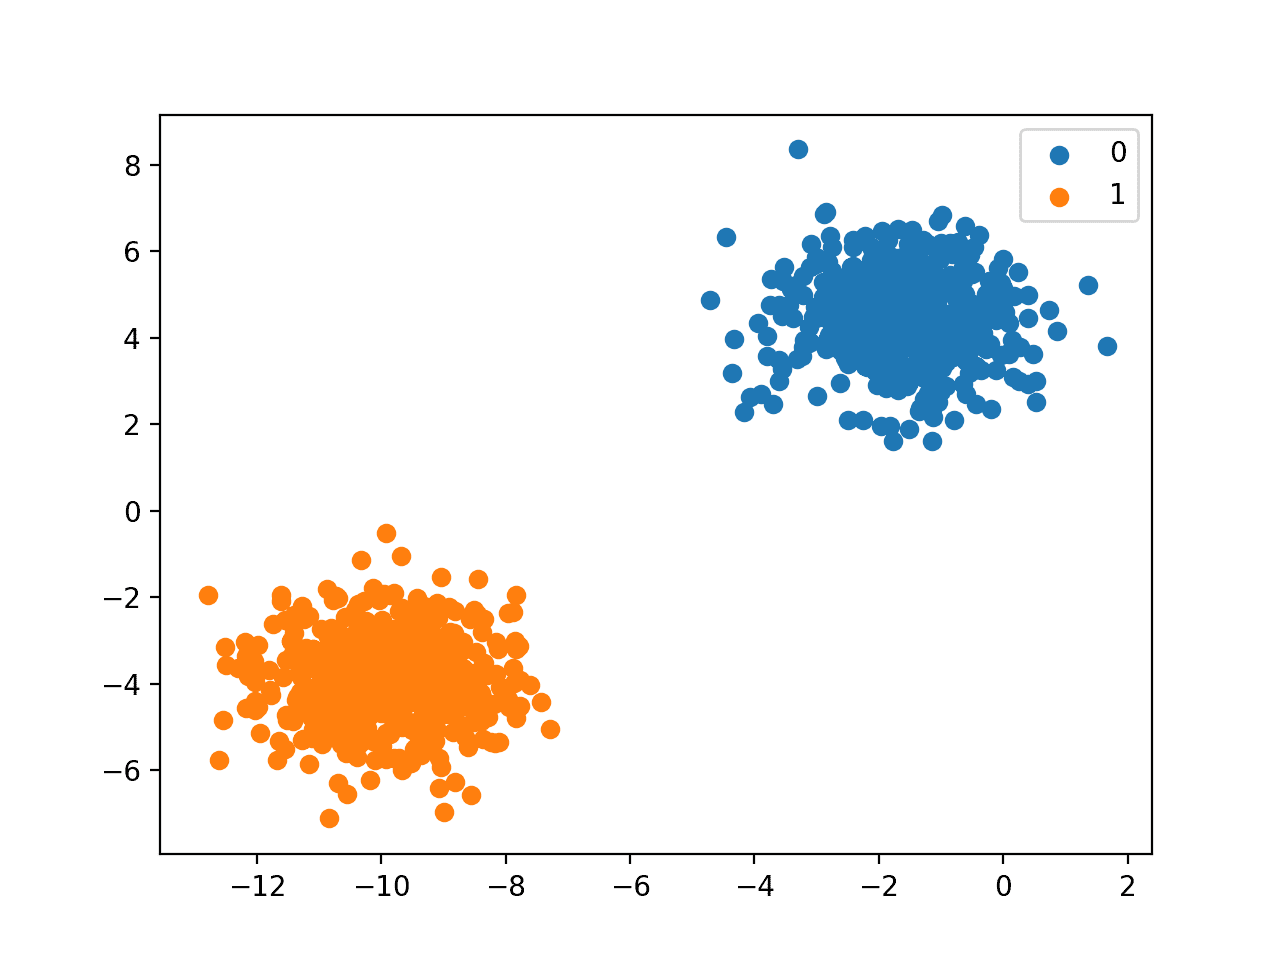

#  Lab: Classification Methods

We will begin by examining some numerical and graphical summaries of the [Smarket](https://rdrr.io/cran/ISLR/man/Smarket.html) data, which is available on [Canvas](https://canvas.instructure.com/). This data set consists of percentage returns for the S&P 500 stock index over 1, 250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and `Direction` (whether the market was `Up` or `Down` on this date). Our goal is to predict `Direction` (a Qualitative response) using the other features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import classes from scikit-learn for logistic regression, LDA, QDA, and KNN classification
# Also import convenience function for computing confusion matrices
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would load statsmodels.formula.api instead
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
Smarket_filepath = "Smarket.csv"
Smarket = pd.read_csv(Smarket_filepath, index_col = "Unnamed: 0")
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


It's always good to examine whether or not there are any missing data

In [3]:
# Check for missing values
Smarket.isna().any()

Year         False
Lag1         False
Lag2         False
Lag3         False
Lag4         False
Lag5         False
Volume       False
Today        False
Direction    False
dtype: bool

In [4]:
Smarket.shape

(1250, 9)

In [5]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [6]:
Smarket["Direction"].value_counts()

Up      648
Down    602
Name: Direction, dtype: int64

Before moving forward, we'll produce a scatterplot matrix of all the variables in the set. To visualize the difference between "Up" days and "Down" days, we'll use the `Direction` column to determine the hue.

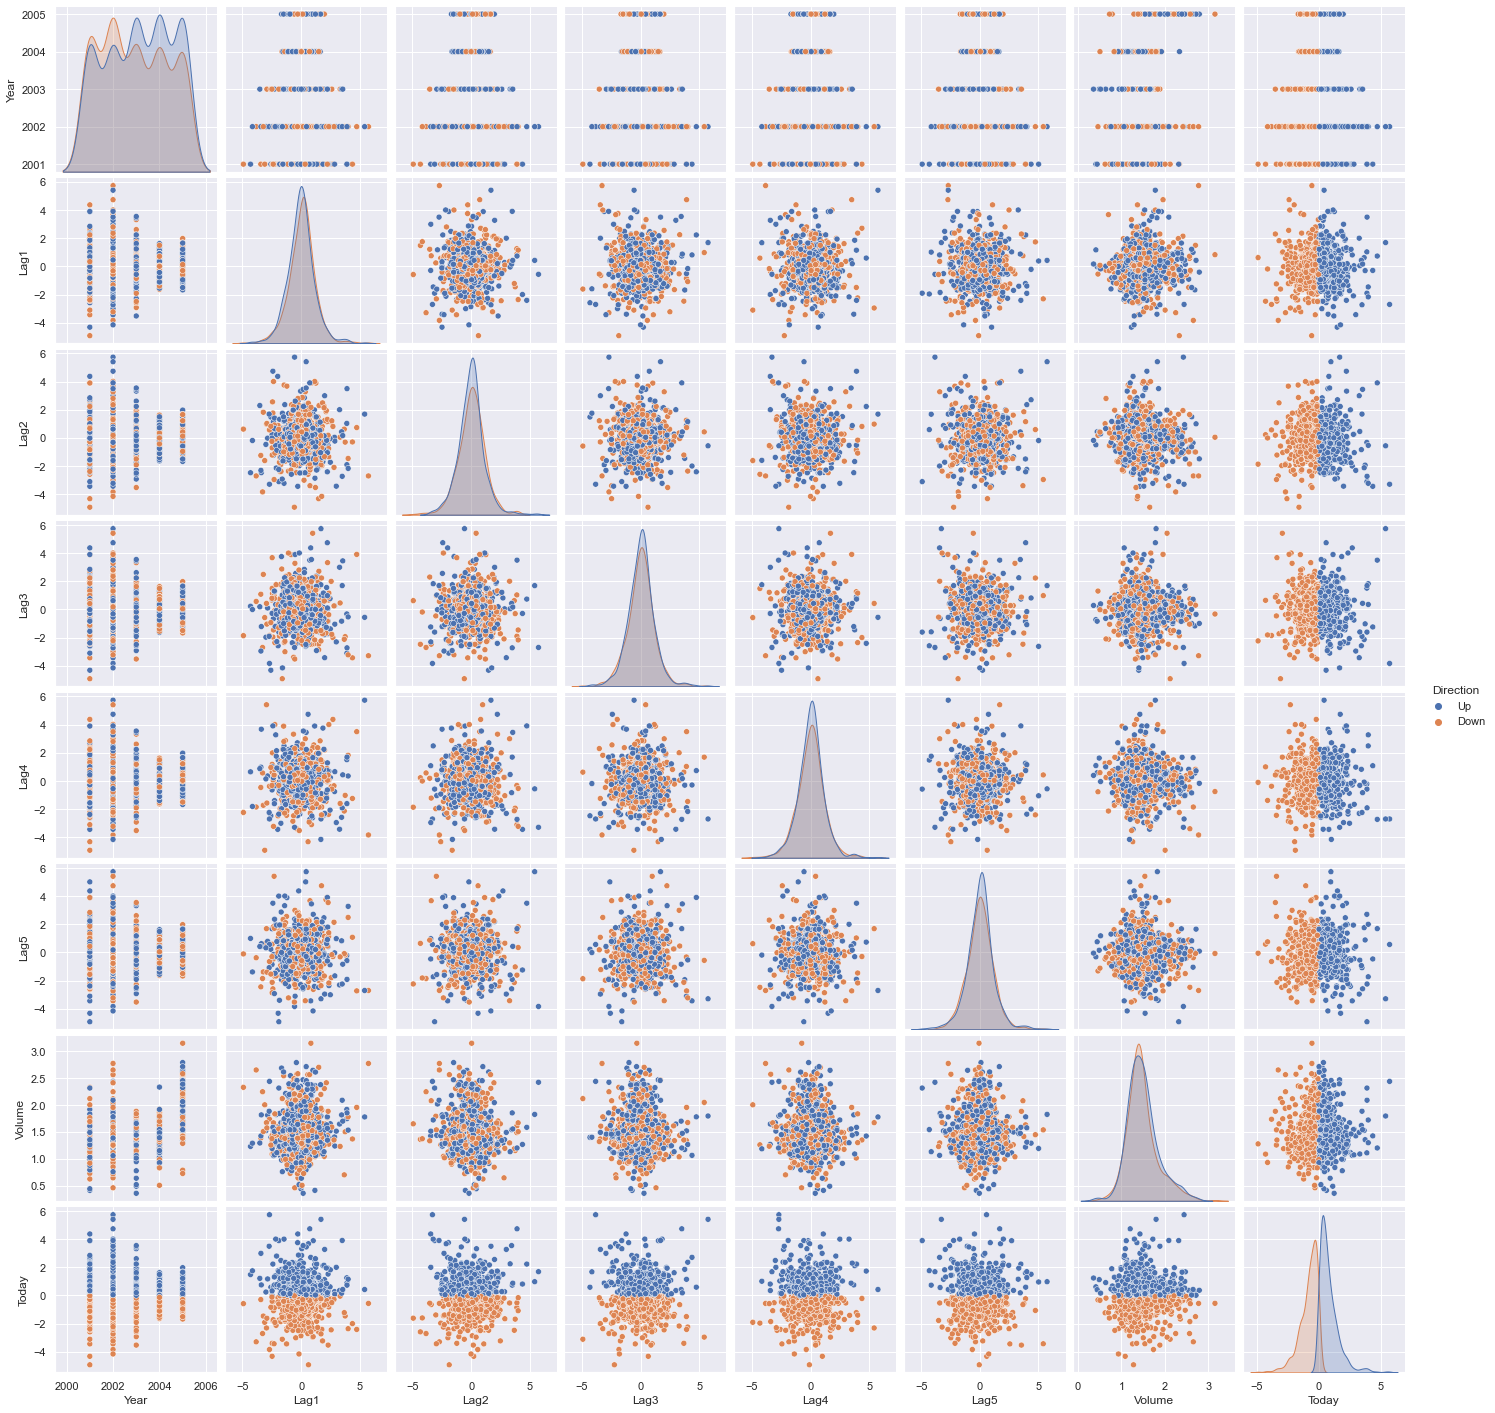

In [7]:
sns.pairplot(Smarket, hue = "Direction")

Next, let's produce a matrix of all the pairwise correlations among the variables in the data set. The `corr()` function in Pandas will automatically ignore qualitative variables.

In [8]:
Smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lag variables and today’s returns are close to zero. In other words, there appears to be little correlation between today’s returns and previous days’ returns. The only substantial correlation is between `Year` and `Volume`. By plotting the data, which is ordered chronologically, we see that Volume is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

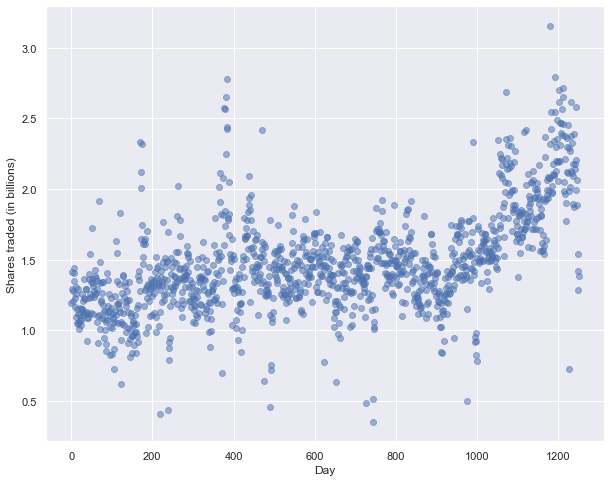

In [9]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x = Smarket.index, y = Smarket["Volume"], alpha = 0.5)
ax.set(xlabel = "Day", ylabel = "Shares traded (in billions)");

##  Logistic Regression

Next, we will fit a logistic regression model in order to predict `Direction` using `Lag1` through `Lag5` and `Volume`. We'll use the [Logit class](http://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit) from StatsModels. Alternatively, with StatsModels, we have the option of using the [GLM class](http://www.statsmodels.org/stable/glm.html) with the family set to [binomial](http://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.Binomial.html#statsmodels.genmod.families.family.Binomial).

In [10]:
# Using the Logit class from StatsModels
# First encode the response numerically
endog = (Smarket["Direction"] == "Up").astype("int64")
exog = sm.add_constant(Smarket.drop(columns = ["Direction", "Year", "Today"]))
logit_mod = sm.Logit(endog, exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Sep 2021   Pseudo R-squ.:                0.002074
Time:                        12:07:20   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

In [11]:
# Using the GLM class from StatsModels
# First encode the response numerically
endog = (Smarket["Direction"] == "Up").astype("int64")
exog = sm.add_constant(Smarket.drop(columns = ["Direction", "Year", "Today"]))
glm_mod = sm.GLM(endog, exog, family = sm.families.Binomial())
glm_res = glm_mod.fit()
print(glm_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Wed, 29 Sep 2021   Deviance:                       1727.6
Time:                        12:07:20   Pearson chi2:                 1.25e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.6

The cool thing about the `GLM` function can be used to fit many types of generalized linear models, including logistic regression.

The smallest *p*-value here is associated with `Lag1`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the *p*-value is still relatively large, and so there is no clear evidence of a real association between `Lag1` and `Direction`.

The coefficients of the fitted model are stored in the params attribute of the fitted model. To see what other properties are stored in the results class for each fitted model, as well as what functions they have, we can either refer to the documentation (LogitResults, GLMResults) or use the `dir` command on a results class object.

In [12]:
logit_res.params

const    -0.126000
Lag1     -0.073074
Lag2     -0.042301
Lag3      0.011085
Lag4      0.009359
Lag5      0.010313
Volume    0.135441
dtype: float64

In [13]:
pd.DataFrame({"Estimate":logit_res.params, "Std. Error":logit_res.bse, "z value":logit_res.tvalues,
             "Pr(>|z|)":logit_res.pvalues})

,Estimate,Std. Error,z value,Pr(>|z|)
const,-0.126000,0.240737,-0.523394,0.600700
Lag1,-0.073074,0.050168,-1.456583,0.145232
Lag2,-0.042301,0.050086,-0.844568,0.398352
Lag3,0.011085,0.049939,0.221974,0.824334
Lag4,0.009359,0.049974,0.187275,0.851445
Lag5,0.010313,0.049512,0.208296,0.834998
Volume,0.135441,0.158361,0.855266,0.392404


Before moving on to making predictions with the model, we'll also use scikit-learn's LogisticRegression class to fit the above logistic regression model. For the purposes of this lab, we won't worry about extending the LogisticRegression class to include all of the statistical parameters and analyses that StatsModels can do.

In [14]:
X = Smarket.drop(columns = ["Direction", "Year", "Today"])
y = Smarket["Direction"]

In [15]:
# By default scikit-learn uses an l2 regularization penalty, which we don't want for
# vanilla logistic regression as described in the book
log_reg = LogisticRegression(penalty = "none", solver = "lbfgs")
log_reg.fit(X, y)
params = np.concatenate((log_reg.intercept_, log_reg.coef_.flatten()))
pd.DataFrame(data = {"Coef. Est.":params}, index = X.columns.insert(0, "intercept"))

,Coef. Est.
intercept,-0.126008
Lag1,-0.073073
Lag2,-0.042301
Lag3,0.011086
Lag4,0.009360
Lag5,0.010313
Volume,0.135446


In order to make a prediction, we use the `predict()` function to use the model to compute the probability that the market will go up for a set of given values of the predictors. When computing the predicted values, by default StatsModels will compute the probabilities  $P(Y=1|X)$  for each observation. If we don't supply a data set to the `exog` parameter of the `predict()` function, then it will compute the probabilties for the training data that was used to fit the model. Here are the first ten probabilities that `predict()` computed.

In [16]:
logit_probs = logit_res.predict()
logit_probs[0:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [17]:
# Predictions from using GLM with the Binomial family
glm_probs = glm_res.predict()
glm_probs[0:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, `Up` or `Down`. More specifically, these values correspond to the probability of the market going up, rather than down, since we specifically coded `1` for `Up` and `0` for `Down` when passing the `Direction` column to StatsModels.

When computing the predicted values using scikit-learn, we use the `predict_proba()` function, which produces an array with a column for the probability of each class label for each observation.

In [18]:
log_reg_probs = log_reg.predict_proba(X)
pd.DataFrame(log_reg_probs, columns = log_reg.classes_).head(10)

,Down,Up
0,0.492916,0.507084
1,0.518533,0.481467
2,0.518861,0.481139
3,0.484778,0.515222
4,0.489219,0.510781
5,0.493043,0.506957
6,0.507349,0.492651
7,0.490771,0.509229
8,0.482387,0.517613
9,0.511162,0.488838


While we can convert the predicted probabilities into class labels `Up` or `Down`, the `predict()` function for `LogisticRegression` in scikit-learn actually does this automatically by assigning each prediction to the class for which it has the highest probability (which in the case of binary classification is the class with probability greater than 0.5).

In [19]:
log_reg_pred = log_reg.predict(X)
pd.DataFrame(np.hstack((log_reg_probs, log_reg_pred.reshape(-1,1))), 
             columns = np.concatenate((log_reg.classes_, ["Prediction"]))).head(10)

,Down,Up,Prediction
0,0.492916,0.507084,Up
1,0.518533,0.481467,Down
2,0.518861,0.481139,Down
3,0.484778,0.515222,Up
4,0.489219,0.510781,Up
5,0.493043,0.506957,Up
6,0.507349,0.492651,Down
7,0.490771,0.509229,Up
8,0.482387,0.517613,Up
9,0.511162,0.488838,Down


In addition, both StatsModels and scikit-learn have convenient methods for generating confusion matrices in order to determine how many observations were correctly or incorrectly labeled. For the Logit class in StatsModels, we use the `pred_table()` function, which can take an optional threshold argument to adjust the threshold probability for assigning an observation to a class. By default the threshold value is 0.5. Also note that `pred_table[i,j]` refers to the number of times `i` was observed and the model predicted `j`. Correct predictions are along the diagonal.

In [20]:
pd.DataFrame(logit_res.pred_table(), columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,145.0,457.0
ActualUp,141.0,507.0


For scikit-learn, we can use the `confusion_matrix()` function, which is part of the metrics subclass. Scikit-learn uses the same axes convention as StatsModels (entry  $C_{i,j}$  of the confusion matrix  $C$  is the number of observations known to be in group  $i$  and predicted to be in group  $j$ ). 

In [21]:
pd.DataFrame(confusion_matrix(y, log_reg_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,145,457
ActualUp,141,507


The diagonal of the confusion matrix represents correct predictions, while the off-diagonal represents incorrect predictions. Thus, the model correctly predicted that the market would go up on 507 days and go down on 145 days, for a total of 652 correct predictions. This means that logistic regression correctly predicted the movement of the market  $652/1250=52.16\%$  of the time. In StatsModels, another way we can compute this is to use the `mean()` function.

In [22]:
logit_preds = pd.Series(logit_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")
(logit_preds == Smarket["Direction"].values).mean()

0.5216

This works because the `logit_preds == Smarket["Direction"].values` is a boolean vector, and in the context of the `mean()` function the value `TRUE` is treated as 1 and `FALSE` is treated as 0. With scikit-learn, we can also use the `score()` function to conveniently perform this computation.

In [23]:
log_reg.score(X, y)

0.5216

Note that this correct prediction rate of $52.16\%$ comes from testing our logistic regression model on the same data set we used for training. In other words, our _training error rate_ is 47.84. Since the training error rate tends to underestimate the test error rate, the correct prediction rate isn't as good as it might initially seem. One way we can better assess the accuracy of the logistic regression model in this setting is to fit the model using part of the data, and then examine how well it performs when predicting the _held out_ data. Since in practice we are more interested with how well our model performs on days in the future for which the market's movements are unknown, this will yield a more realistic error rate. In order to implement this strategy, we'll again use a boolean mask to separate out the observations from 2001 through 2004 from the observations from 2005.

In [24]:
train_mask = (Smarket["Year"] < 2005)

To start with, we create a boolean mask where each element is either `TRUE` if it corresponds to an observation that occurred before 2005 or `FALSE` if it corresponds to an observation that occurred in 2005.

We can then use the mask to pick out the submatrix of the stock market data set which consists of all columns, and only the rows for which the elements of train are false. In other words, `Smarket_2005` is a copy of the submatrix of `Smarket` consisting only of all observations from 2005. Note that we didn't need to create the mask `train` separately, but doing so is good practice to allow us to easily manipulate our training set in a single place.

In [25]:
# Recall that to to element-wise logical operators for boolean indexing in Pandas, we need to use
# | for or, & for and, ~ for not
Smarket_2005 = Smarket[~train_mask]
Smarket_2005.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
999,2005,-0.134,0.008,-0.007,0.715,-0.431,0.7869,-0.812,Down
1000,2005,-0.812,-0.134,0.008,-0.007,0.715,1.5108,-1.167,Down
1001,2005,-1.167,-0.812,-0.134,0.008,-0.007,1.7210,-0.363,Down
1002,2005,-0.363,-1.167,-0.812,-0.134,0.008,1.7389,0.351,Up
1003,2005,0.351,-0.363,-1.167,-0.812,-0.134,1.5691,-0.143,Down


Now we'll train our logistic regression model on the training set (consisting of the observations from the years 2000-2004) before testing the model on our held-out test set.

In [26]:
# Using the Logit class from StatsModels, and training only on the training set
# First encode the response numerically
train_endog = (Smarket.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(Smarket[train_mask].drop(columns = ["Direction", "Year", "Today"]))
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


Again we emphasize that we are training and testing our model on two completely separate data sets: we used only the dates from before 2005 for training, and only used dates from 2005 for testing. Again let's compute the predictions for 2005 and compare them to the actual movements of the market over that time period.

In [27]:
test_exog = sm.add_constant(Smarket[~train_mask].drop(columns = ["Direction", "Year", "Today"]))
test_endog = Smarket.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")
pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,77,34
ActualUp,97,44


In [28]:
(logit_test_preds == Smarket_2005["Direction"].values).mean()

0.4801587301587302

In [29]:
(logit_test_preds != Smarket_2005["Direction"].values).mean()

0.5198412698412699

Now we repeat the process using scikit-learn.

In [30]:
# Using LogisticRegression from scikit-learn
# First separate out the training and test sets
X_train = Smarket[train_mask].drop(columns = ["Direction", "Year", "Today"])
y_train = Smarket.loc[train_mask, "Direction"]
X_test = Smarket[~train_mask].drop(columns = ["Direction", "Year", "Today"])
y_test = Smarket.loc[~train_mask, "Direction"]

# Fit the model using the training set
log_reg = LogisticRegression(penalty = "none", solver = "lbfgs")
log_reg.fit(X_train, y_train)

#Test the model using the held-out test set
log_reg_pred = log_reg.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, log_reg_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,77,34
ActualUp,97,44


In [31]:
log_reg.score(X_test, y_test)

0.4801587301587302

In [32]:
1 - log_reg.score(X_test, y_test)

0.5198412698412698

Here, we see that when we used separate training and testing sets the test error rate is about 52%, which is worse than random guessing! This suggests that we should try to experiment some more to see if we can improve our model. One thing we can try is removing the variables that didn't seem to be helpful in predicting `Direction` and refit the logistic regression model. As we recall, none of the *p*-values for the predictors were particularly small, even the smallest one which corresponded to `Lag1`. Since using predictors that have no relationship with the response increase the variance of a model without a corresponding decrease in bias, they therefore tend to negatively impact the test error rate. Let's try refitting the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model. Again we start by doing this with StatsModels.

In [33]:
# Using the Logit class from StatsModels, and training only on the training set
# Separate out the training and test sets
# Then encode the response numerically
train_endog = (Smarket.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(Smarket.loc[train_mask, ["Lag1", "Lag2"]])
test_exog = sm.add_constant(Smarket.loc[~train_mask, ["Lag1", "Lag2"]])
test_endog = Smarket.loc[~train_mask, "Direction"]

# Fit logistic regression model using the training set
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()

# Test the model using the held-out test set
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")
pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


,PredDown,PredUp
ActualDown,35,76
ActualUp,35,106


In [34]:
(logit_test_preds == Smarket_2005["Direction"].values).mean()

0.5595238095238095

Now we repeat the process using scikit-learn.

In [35]:
# Using LogisticRegression from scikit-learn
# First separate out the training and test sets
X_train = Smarket.loc[train_mask, ["Lag1", "Lag2"]]
y_train = Smarket.loc[train_mask, "Direction"]
X_test = Smarket.loc[~train_mask, ["Lag1", "Lag2"]]
y_test = Smarket.loc[~train_mask, "Direction"]

# Fit the model using the training set
log_reg = LogisticRegression(penalty = "none", solver = "lbfgs")
log_reg.fit(X_train, y_train)

#Test the model using the held-out test set
log_reg_pred = log_reg.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, log_reg_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,35,76
ActualUp,35,106


In [36]:
log_reg.score(X_test, y_test)

0.5595238095238095

Here things look a little better, since about 56% of the daily movements in 2005 were correctly predicted. However, if we predicted that the market would increase every day we would also have the same error rate.

In [37]:
(Smarket_2005["Direction"] == "Up").mean()

0.5595238095238095

Thus, in terms of the overall error rate, logistic regression is no better than naively predicting that the market would increase every day. However, when we examine the confusion matrix a little more closely we can see that on days when logistic regression predicts an increase in the maket, it has a slightly better accuracy rate of  $106/(106+76)=0.582$ . This suggests a possible strategy of buying on days when the model predicts an increasing market, and avoiding trades when the model predicts a decreasing market. Without further investigation, though, we do not know if this small improvement is real or just due to random chance.

Lastly, if we wish to predict the returns associated with particular values of Lag1 and Lag2, such as on a day when `Lag1 = 1.2` and `Lag2 = 1.1`, or on a day when `Lag1 = 1.5` and `Lag2 = -0.8`, we can do this using the `predict()` function in StatsModels or `predict_proba()` function in scikit-learn if we want the raw probabilities. As already mentioned, the `predict()` function in scikit-learn will give the predicted class labels.

In [38]:
df = pd.DataFrame({"Lag1": [1.2, 1.5], "Lag2":[1.1, -0.8]})

In [39]:
# Using StatsModels to generate predicted probabilities for particular values of Lag1 and Lag2
logit_res.predict(sm.add_constant(df))

0    0.479146
1    0.496094
dtype: float64

In [40]:
# Using scikit-learn to generate predicted probabilities for particular values of Lag1 and Lag2
pd.DataFrame(log_reg.predict_proba(df), columns = log_reg.classes_)

,Down,Up
0,0.520854,0.479146
1,0.503889,0.496111


In [41]:
# Using scikit-learn to directly computed predicted class labels
log_reg.predict(df)

array(['Down', 'Down'], dtype=object)

## Linear Discriminant Analysis

Next, we'll perform linear discriminant analysis (LDA) on the `Smarket` data. Since StatsModels does not support LDA, we'll only be using the LinearDiscriminantAnalysis class from scikit-learn. Just as we did with the second attempt at using logistic regression, we'll only use the observations from before 2005 to fit the model, and we'll only use `Lag1` and `Lag2` as the predictors.

Note that there are three solvers that the LinearDiscriminantAnalysis class can use:

 - Singular value decomposition `svd` (default): Does not compute covariance matrix, which can be advantageous when there are a large number of features. It can be used for both classification and transformation, though it does not support shrinkage.
 - Least squares `lsqr`: An efficient algorithm, though it can only be used for classification. It does support shrinkage.
 - Eigenvalue decomposition `eigen`: Based on optimizing the "between class scatter" to "within class scatter" ratio. It can be used for both classification and transformation, and also supports shrinkage. Since it needs to compute the covariance matrix, it might not be suitable for situations when there are a large number of features.

The coefficients computed using least squares are slightly different from those obtained when using singular value decomposition or eigenvalue decomposition, but overall classification performance should be essentially the same.

In [42]:
# First separate out the training and test sets
X_train = Smarket.loc[train_mask, ["Lag1", "Lag2"]]
y_train = Smarket.loc[train_mask, "Direction"]
X_test = Smarket.loc[~train_mask, ["Lag1", "Lag2"]]
y_test = Smarket.loc[~train_mask, "Direction"]

# Fit the LDA model using the training set
lda_clf = LinearDiscriminantAnalysis(store_covariance = True)
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [43]:
# Prior probabilities for the classes
pd.Series(lda_clf.priors_, index = lda_clf.classes_)

Down    0.491984
Up      0.508016
dtype: float64

In [44]:
# Group means for each predictor within each class
pd.DataFrame(lda_clf.means_, index = lda_clf.classes_, columns = X_train.columns)

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


In [45]:
# Coefficients for linear discriminants
pd.Series(lda_clf.coef_.flatten(), index = X_train.columns)

Lag1   -0.055441
Lag2   -0.044345
dtype: float64

First, we note that `lda_clf.priors_` indicates that the estimated prior probabilities of the groups are  $\hat{\pi_1}=0.492$  and  $\hat{\pi_2}=0.508$ . This means that 49.2% of the training observations correspond to days during which the market went down and 50.8% of the training observations correspond to days during which the market went up. In addition, the output also provides the averages of each predictor within each class (e.g. the average value of `Lag1` for days in which the market went down is 0.0428) with `lda_clf.means_`, which are used in LDA as estimates of the actual group means  $\mu_k$ . These suggest that there is a tendency for the previous two days' returns to be negative on the days when the market increases, and a tendency for the previous two days' returns to be positive on the days when the market decreases. Lastly, `lda_clf.coef_` provides the coefficients of `Lag1` and `Lag2` that are used to form the LDA decision rule. In other words, we can think of these as the multipliers of the elements of  $X=x$  in the formula

$\delta_{k}(x)=x^T \Sigma^{-1}\mu_k - \frac{1}{2} \mu^T_{k}\Sigma^{-1}\mu_k + log(\pi_k)$

Recall that in the fomula  $\Sigma$  is the  $2×2$  covariance matrix of `Lag1` and `Lag2`;  $\mu_k$  is the vector of the group means of `Lag1` and `Lag2` for either the group `Down` or the group `Up`;  $\pi_k$  is the estimated prior probability of either `Down` or `Up`. Strictly speaking, since we are using estimates in the model,  $\Sigma$,  $\mu_k$ , and  $\pi_k$  should be replaced with their hatted versions. Also recall that this formula is the vector/matrix version of

$\delta_{k} = x\frac{\mu_k}{\sigma^2} - \frac{\mu^2_{k}}{2\sigma^2} + log(\pi_k)$

When working with just two classes  $k$  and  $l$ , the coefficients are actually from the log-ratio description of LDA, which is discussed in Section 4.3 (Formula 4.9) of Elements of Statistical Learning, as explained in the [user guide page for linear and quadratic discriminant analysis](https://scikit-learn.org/stable/modules/lda_qda.html).

$log \frac{Pr(G=k|X=x}{Pr(G=l|X=x} = x^T \Sigma^{-1}\left(\mu_k - \mu_l \right) - \frac{1}{2}\left(\mu_k + \mu_l \right)^T\Sigma^{-1} \left(\mu_k - \mu_l \right) + log\frac{\pi_k}{\pi_l}$

More concretely, if  $−0.055441 ×  Lag1  −0.044345 ×  Lag2$ is large, then the LDA classifier will predict a market increase; if it is small, then the LDA classifier will predict a market decline.

In [46]:
# Scalings for linear discriminants
pd.Series(lda_clf.scalings_.flatten(), index = X_train.columns)

Lag1   -0.642019
Lag2   -0.513529
dtype: float64

In addition to the classifier coefficients, the LinearDiscriminantAnalysis class also computes scaled coefficients, stored as `lda_clf.scalings_`, which are the coefficients printed out by `lda()` in `R`. One way of thinking about the scalings is that they are the LDA coefficients one would obtain after normalizing the data so that the within groups covariance matrix is spherical (also known as [whitening](https://theclevermachine.wordpress.com/2013/03/30/the-statistical-whitening-transform/) the data to have an identity covariance matrix), as discussed in the [`R` documentation for `lda()`](https://www.rdocumentation.org/packages/MASS/versions/7.3-51.4/topics/lda). More of the underlying mathematics of the scaled coefficients is discussed in detail in this [stats.stackexchange post](https://stats.stackexchange.com/a/48859) and can also be found in the source code for the LinearDiscriminantAnalysis class, as well as the section of the user guide decribing how to use [LDA for dimensionality reduction](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction). One last mathematical source is Section 4.3.2 in *Elements of Statistical Learning*. Looking under the hood at the source code for the `_solve_eigen()` function, which is used to compute the model via an eigenvalue decomposition, we can more clearly see the relationship between `scalings_`, which are eigenvectors in the decomposition used for solving, and the original values of `coef_`.

To confirm those relationships, we compute the by hand below.

In [47]:
# Computing the coefficients for Lag1 and Lag2 using the log-ratio formula above
# These coefficients match with the coefficient values obtained when using the least-squares solver
np.linalg.inv(lda_clf.covariance_) @ (lda_clf.means_[1] - lda_clf.means_[0])

array([-0.05555211, -0.04443425])

In [48]:
# Relating the coefficients with the scaling values
# These are the coefficients when using the singular value decomposition
# or eigenvalue decomposition solver
orig_coefs = np.dot(lda_clf.means_, lda_clf.scalings_).dot(lda_clf.scalings_.T)
log_ratio_coefs = orig_coefs[1, :] - orig_coefs[0, :]
log_ratio_coefs

array([-0.05544078, -0.0443452 ])

Before moving forward, we can compute the LDA scores using the `decision_function()` method. When performing binary classification, as we are doing in this lab, the scores computed will be the log-ratio scores. In this case, a value greater than zero means that the class corresponding to `lda_clf.classes_[1]` will be predicted.

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log-ratio score'>

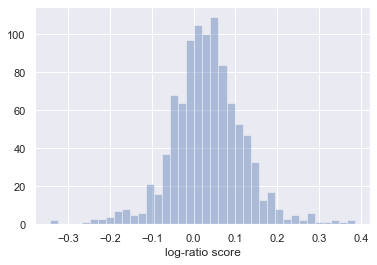

In [49]:
lda_scores = lda_clf.decision_function(X_train)
sns.distplot(lda_scores, kde = False, axlabel = "log-ratio score")

There are four methods that the LinearDiscriminantAnalysis class can use for prediction-related computations.

 - `predict()` contains LDA's predictions about the movement of the market.
 - `predict_proba()` is a matrix whose *k* th column contains the posterior probability that the corresponding observation belongs to the *k*th class. This is computed using Bayes' theorem.
 - `decision_function()` contains the linear discriminant scores (log-ratio scores in binary classification), as described earlier.
 - `score()` computes the accuracy on the given test data by computing the mean accuracy of `predict()` with respect to the true class labels.
 
Recall that Bayes' theorem states that

$Pr(Y=k|X=x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^K\pi_l f_l(x)}$

where  $K$  is the total number of classes for  $Y$ ;  $\pi_k$  is the overall, or prior probability that a randomly chosen observation comes from the  $k$th class; and  $f_k(x)$  is defined to be  $Pr(X=x|Y=k)$ , the probability that  $X=x$  for an observation  $X$  that comes from the  $k$th class.

In [50]:
lda_pred = lda_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, lda_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,35,76
ActualUp,35,106


Recall that in Section 4.5 of the book, we saw that LDA and logistic regression often have similar performance. We see that this is the case for our stock market data. In fact, it just so happens that we have an identical confusion matrix and test accuracy number compared to the logistic regression model.

In [51]:
lda_clf.score(X_test, y_test)

0.5595238095238095

Notice that since there are two classes, LDA uses a posterior probability threshold of 50% in order to make the predictions that go into class.

In [52]:
lda_pred_probs = pd.DataFrame(lda_clf.predict_proba(X_test), columns = lda_clf.classes_)
lda_pred_probs.head()

,Down,Up
0,0.490179,0.509821
1,0.479218,0.520782
2,0.466818,0.533182
3,0.474001,0.525999
4,0.492788,0.507212


In [53]:
pd.Series(lda_pred).head()

0    Up
1    Up
2    Up
3    Up
4    Up
dtype: object

If we wanted to use a posterior probability threshold other than 50% in order to make predictions, we can use a boolean mask with the matrix of posterior probabilities. For example, let's suppose we wish to predict a market decrease only if we are very certain that it will indeed decrease on that day -- say, if the posterior probability of a decrease is at least 90%.

In [54]:
(lda_pred_probs["Down"] > 0.9).sum()

0

No days in 2005 meet that threshold. In fact, the greatest posterior probability of decrease in all of 2005 was 52.02%.

In [55]:
lda_pred_probs["Down"].max()

0.5202349505356155

Moreover, the overall greatest posterior probability for all of 2005 is only 54.22%.

In [56]:
lda_pred_probs.max()

Down    0.520235
Up      0.542213
dtype: float64

## Quadratic Discriminant Analysis

Next, let's fit a quadratic discriminant analysis (QDA) model to the Smarket data. QDA is also part of `sklearn.discriminant_analysis` as the `QuadraticDiscriminantAnalysis()` class. It uses the same syntax as that of `LinearDiscriminantAnalysis`, though it doesn't have the option to choose a solver aside from singular value decomposition.

In [57]:
# First separate out the training and test sets
X_train = Smarket.loc[train_mask, ["Lag1", "Lag2"]]
y_train = Smarket.loc[train_mask, "Direction"]
X_test = Smarket.loc[~train_mask, ["Lag1", "Lag2"]]
y_test = Smarket.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [58]:
# Prior probabilities for the classes
pd.Series(qda_clf.priors_, index = qda_clf.classes_)

Down    0.491984
Up      0.508016
dtype: float64

In [59]:
# Group means for each predictor within each class
pd.DataFrame(qda_clf.means_, index = qda_clf.classes_, columns = X_train.columns)

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


While the `QuadraticDiscriminantAnalysis` class stores many of the same parameters as the `LinearDiscriminantAnalysis` class, such as the prior probabilities of the groups (`qda_clf.priors_`) as well as the group means (`qda_clf.means_`), it does not have a parameter storing coefficients of the linear discriminants. This is because the QDA classifier involves a quadratic, not linear, function of the predictors. Recall that in QDA the formula  $\delta_k(x)$ , the posterior probability that the observation  $X=x$  is a member of the  $k$th class, is

$\delta_k(x)=−\frac{1}{2}(x−\mu_k)^T\Sigma_{k}^-1(x−\mu_k)−\frac{1}{2}log|\Sigma_{k}|+log(\pi_k) \\ 
=−\frac{1}{2}x^T\Sigma_{k}^-1x+x^T\Sigma_{k}^-1\mu_k−\frac{1}{2}\mu_{k}^T\Sigma_{k}^-1\mu_k−\frac{1}{2}log|\Sigma_{k}|+log(\pi_k),$
 
where observations from the  $k$th class are normally distributed with (population) mean  $\mu_k$  and (population) covariance matrix  $\Sigma_{k}$ . This comes from the assumption in QDA that each class has its own covariance matrix, which differs from the assumption in LDA that the classes had the same covariance matrix.

Even though the `QuadraticDiscriminantAnalysis` class is slightly different in the parameters it stores, it has the same four prediction-related methods as `LinearDiscriminantAnalysis` (`predict()`, `predict_proba()`, `decision_function()`, and `score()`.

In [60]:
qda_pred = qda_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, qda_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,30,81
ActualUp,20,121


In [61]:
qda_clf.score(X_test, y_test)

0.5992063492063492

Here, we see that the QDA predictions are accurate almost 60% of the time for the 2005 data, which wasn't used to fit the model. This suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression. However, this model should be evaluated on a larger test set to get a better sense of its predictive strength.

As a side note, we can again use a boolean mask with the matrix of posterior probabilities to make predictions with a probability threshold that is different from 50%. Let's see what QDA says for the cautious scenario of using a 90% probability threshold to predict a decrease.

In [62]:
qda_pred_probs = pd.DataFrame(qda_clf.predict_proba(X_test), columns = lda_clf.classes_)
(qda_pred_probs["Down"] > 0.9).sum()

0

Again no days in 2005 meet this threshold, since the maximum posterior probability of a decrease in all of 2005 was just 52.24%, and the overall maximum posterior probability in all of 2005 was 54.62%.

In [63]:
qda_pred_probs.max()

Down    0.522407
Up      0.546185
dtype: float64

## K-Nearest Neighbors

The last method of working with the `Smarket` data we'll use is *K*-nearest neighbors. To do this, we'll use the `KNeighborsClassifier` class from the `sklearn.neighbors` module. For basic documentation, we refer to the [user guide section on nearest neighbors classification](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification), as well as the documentation page for the `KNeighborsClassifier` class. Unlike the *KNN* classifier in `R`, one benefit of using scikit-learn is the fact that the process for fitting the model and then using it to make predictions is consistent with the previous classifiers we have used in this lab.

Note that the `KNeighborsClassifier` takes a few arguments that are worth pointing out.

 - `n_neighbors`: This is the value of  K . By default it is 5.
 - `weights`: A weight function which allows us to weight the neighbors when performing prediction. This can either be uniform weighting (the default); inverse-distance weighting to give closer neighbors higher weight values than further ones; or a user-defined weight function.
 - `algorithm`: The algorithm used to compute the nearest neighbors. The options are BallTree, KDTree, brute-force, and attempting to automatically choose one based on the values passed to the fit() method.
 - `metric`: The distance metric used to measure the distance between neighbors. There are a number of options described in the DistanceMetric class. By default Euclidean distance (i.e. Minkowski distance with  p=2 ) is used.

For the purposes of this lab, the only parameter which we will modify is `n_neighbors`.

In [64]:
# First separate out the training and test sets
X_train = Smarket.loc[train_mask, ["Lag1", "Lag2"]]
y_train = Smarket.loc[train_mask, "Direction"]
X_test = Smarket.loc[~train_mask, ["Lag1", "Lag2"]]
y_test = Smarket.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility for our results
np.random.seed(1)

# Fit the KNN model using the training set and K = 1
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Note that in order to have consistency and have reproducibility for our results, we set a random seed before performing `KNeighborsClassifier.fit()` since Python randomly breaks any ties if several observations are tied as nearest neighbors.

In [65]:
knn_1_pred = knn_1_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, knn_1_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,43,68
ActualUp,58,83


Using  $K$=1 , our results aren't very good, since only  $(43+83)/252=50%$  of the observations are correctly predicted. Of course, using  $K$=1  is a very flexible fit, so perhaps it was too much flexibility. Let's try again using  $K$=3 .

In [66]:
# Fit the KNN model using the training set and K = 3
knn_3_clf = KNeighborsClassifier(n_neighbors = 3)
knn_3_clf.fit(X_train, y_train)
knn_3_pred = knn_3_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, knn_3_pred), 
             columns = ["PredDown", "PredUp"], index = ["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,48,63
ActualUp,55,86


In [67]:
knn_3_clf.score(X_test, y_test)

0.5317460317460317

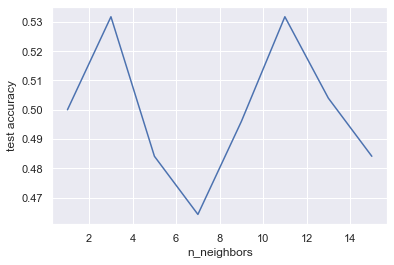

In [68]:
knn_scores = []
for k in range(1, 16, 2):
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    knn_clf.fit(X_train, y_train)
    knn_scores.append(knn_clf.score(X_test, y_test))
fig = plt.figure()
ax = plt.axes()
ax.plot(range(1, 16, 2), knn_scores)
ax.set(xlabel = "n_neighbors", ylabel = "test accuracy");

The results improved slightly to about 53.2% test accuracy, though further increasing  $K$  does not provide any additional improvements. For this data, it appears that QDA provides the best results of the methods we have examined thus far.

## An Application to Caravan Insurance Data

Lastly, we'll use KNN with the Caravan data set from the ISLR library. This set includes 85 predictors that measure demographic characteristics for 5,822 individuals. The response variable is Purchase which indicates whether or not a given individual purchases a caravan insurance policy. After loading the data into a Pandas dataframe, let's explore it a little bit.

In [69]:
caravan_filepath="https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Caravan.csv" #i found a csv here
caravan = pd.read_csv(caravan_filepath, index_col = "Unnamed: 0")
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In this set, only about 6% of people purchased caravan insurance.

In [70]:
caravan["Purchase"].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [71]:
(caravan["Purchase"] == "Yes").mean()

0.05977327378907592

Before proceeding, we note that since the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Variables with a large scale will have a much larger effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale. For example, if we have a data set with the variables `salary` (measured in dollars) and `age` (measured in years), a difference of \\$1000 in salary is quite large compared to a difference of 50 years of age when it comes to computing distances in KNN. As a result, `salary` will dominate the KNN classification results while `age` will have almost no effect. Moreover, the importance of scale to the KNN classfier means that changing the units (such as measuring `salary` in Japanese yen, or measuring `age` in minutes) of the predictors could result in vastly different classification results compared to what we would get when using dollars and years.

One way to handle this problem is to *standardize* the data so that all variables are given a mean of zero and a standard deviation of one. Doing this will put all variables on a comparable scale. While we could do this by hand, it is much more convenient to use the `transform()` [function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html#pandas.DataFrame.transform) as described in the section on [split-apply-combine in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation). When doing this with the `Caravan` data, we exclude the qualitative `Purchase` variable.

In [72]:
standardized_X = caravan.drop(columns = ["Purchase"]).transform(lambda x: (x - x.mean())/x.std())

We can check the mean and variance of first two columns of `Caravan` and compare those with that of the standardized columns to confirm that the standardized ones have mean zero and standard deviation one.

In [73]:
caravan.mean().head()

MOSTYPE     24.253349
MAANTHUI     1.110615
MGEMOMV      2.678805
MGEMLEEF     2.991240
MOSHOOFD     5.773617
dtype: float64

In [74]:
standardized_X.mean().head()

MOSTYPE     5.261260e-17
MAANTHUI    2.073039e-16
MGEMOMV    -1.033144e-15
MGEMLEEF    1.749258e-16
MOSHOOFD   -4.877964e-17
dtype: float64

Note that the standardized means aren't exactly equal to zero due to slight floating point precision errors.

In [75]:
caravan.var().head()

MOSTYPE     165.037847
MAANTHUI      0.164708
MGEMOMV       0.623839
MGEMLEEF      0.663555
MOSHOOFD      8.161077
dtype: float64

In [76]:
standardized_X.var().head()

MOSTYPE     1.0
MAANTHUI    1.0
MGEMOMV     1.0
MGEMLEEF    1.0
MOSHOOFD    1.0
dtype: float64

Now we split the observations into a test set, containing the first 1,000 observations, and a training set, containing the remaining observations.

In [77]:
test_mask = range(1, 1001)
X_train = standardized_X.drop(index = test_mask)
X_test = standardized_X.loc[test_mask, ]
y_train = caravan.drop(index = test_mask)["Purchase"]
y_test = caravan.loc[test_mask, "Purchase"]

Once we have separated out the training and test observations, we start off by fitting a KNN model on the training data using  $K$=1  and then evaluate is performance on the test data.

In [78]:
# Set NumPy random seed for consistency and reproducibility for our results
np.random.seed(1)

# Fit the KNN model using the training set and K = 1
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [79]:
1 - knn_1_clf.score(X_test, y_test)

0.118

The KNN error rate with  $K$=1  is just under 12%, which appears to be pretty good at a first glance. However, since only 6% of customers purchased insurance, we could get the error rate down to 6% just by always predicting `No` regardless of the values of the predictors.

In [80]:
(y_test != "No").mean()

0.059

While the overall error rate is rather low, depending on the situation we may be interested in other methods of measuring the quality of the model. For example, if there is some non-trivial cost to trying to sell insurance to a given individual, then the company would like to try and sell insurance only to customers who are likely to buy it. In that case, the company is more interested in the fraction of individuals that are correctly predicted to buy insurance.

In [81]:
knn_1_pred = knn_1_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, knn_1_pred), 
             columns = ["PredNo", "PredYes"], index = ["ActualNo", "ActualYes"])

,PredNo,PredYes
ActualNo,873,68
ActualYes,50,9


Looking at the fraction of individuals that are correctly predicted to buy insurance, the KNN classifier with  $K$=1  does far better than random guessing among the customers that are predicted to buy insurance. Among the 77 customers it predicted to buy insurance, 9 (11.7%) of them actually do purchase insurance. This is double the rate one would obtain from random guessing.

We can also explore other values of  $K$ , such as  $K$=3  and  $K$=5 , to see how performance changes.

In [82]:
# Using K = 3
knn_3_clf = KNeighborsClassifier(n_neighbors = 3)
knn_3_clf.fit(X_train, y_train)
knn_3_pred = knn_3_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, knn_3_pred), 
             columns = ["PredNo", "PredYes"], index = ["ActualNo", "ActualYes"])

,PredNo,PredYes
ActualNo,921,20
ActualYes,54,5


In [83]:
# Using K = 5
knn_5_clf = KNeighborsClassifier(n_neighbors = 5)
knn_5_clf.fit(X_train, y_train)
knn_5_pred = knn_5_clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, knn_5_pred), 
             columns = ["PredNo", "PredYes"], index = ["ActualNo", "ActualYes"])

,PredNo,PredYes
ActualNo,930,11
ActualYes,55,4


With  $K$=3 , the success rate of correctly predicting customers who buy insurance increases to  $5/25=20%$, and with  $K$=5  the rate is  $4/15=26.7%$ . That is over four times the rate that we get from random guessing! This suggests that KNN is finding some real patterns in a difficult data set.

To compare, we can also fit a logistic regression model to the data.

In [84]:
# Using the Logit class from StatsModels, and training only on the training set
# Separate out the training and test sets
# Then encode the response numerically
train_endog = (y_train == "Yes").astype("int64")
train_exog = sm.add_constant(X_train)
# Need to use has_constant = "add" to force StatsModels to include a constant term;
# X_test coincidentally happens to have a column which is already constant
test_exog = sm.add_constant(X_test, has_constant = "add")
test_endog = y_test

# Fit logistic regression model using the training set
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()

# Test the model using the held-out test set
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Yes" if (x > 0.5) else "No")
pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), 
             columns = ["PredNo", "PredYes"], index = ["ActualNo", "ActualYes"])

         Current function value: 0.192013
         Iterations: 35


D:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,PredNo,PredYes
ActualNo,934,7
ActualYes,59,0


As we can see, if we use 0.5 as the predicted probability cut-off for logistic regression, only seven of the test observations are predicted to purchase insurance. Even worse, all seven of these predictions are incorrect!

In [85]:
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Yes" if (x > 0.25) else "No")
pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), 
             columns = ["PredNo", "PredYes"], index = ["ActualNo", "ActualYes"])

,PredNo,PredYes
ActualNo,919,22
ActualYes,48,11


We aren't required to use a cut-off of 0.5, though. If we instead use a cut-off of 0.25, we get much better results: we predict that 33 people will purchase insurance, and we are correct for 33% of these people. This is over five times better than random guessing!